In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 16

In [2]:
import os
import sys
import kplr
import h5py
import fitsio
import numpy as np

from scipy.linalg import cho_solve

import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

In [8]:
from ketu.cdpp import compute_cdpp
from ketu.k2.data import K2LightCurve

In [19]:
lc_dir = "/Users/dfm/data/k2/"

In [209]:
epicid = "201374602"
# epicid = "201180709"
fn = lc_dir + "lightcurves/c1/{0}00000/{1}000/ktwo{2}-c01_lpd-lc.fits".format(epicid[:4], epicid[4:6], epicid)

In [210]:
client = kplr.API()
star = client.k2_star(epicid)

In [211]:
_, hdr = fitsio.read(fn, header=True)
base_time = hdr["BJDREFI"] + 1975

In [212]:
lc = K2LightCurve(fn)
lc.prepare(lc_dir + "elcs/c1.h5", nbasis=150)

3576 3597
3571 3576
3570 3571
3570 3570


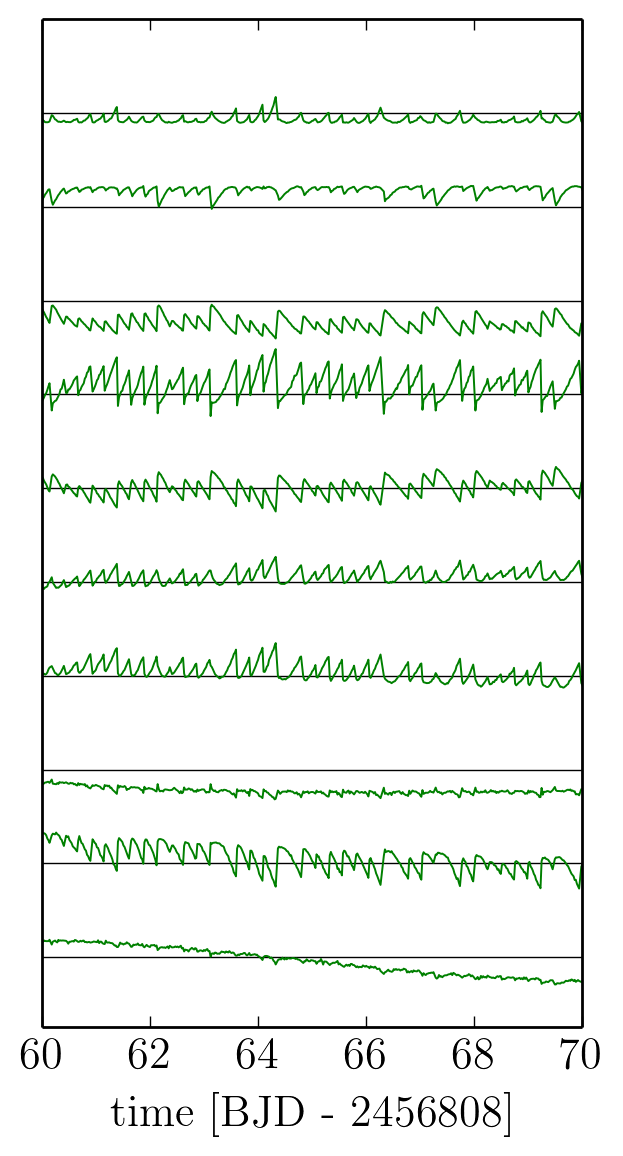

In [213]:
pl.figure(figsize=(3, 6))
pl.axes([0.05, 0.13, 0.9, 0.84])
t = lc.time
offset = 2
for i in range(10):
    pl.gca().axhline(-offset * i, color="k", lw=0.5)
    rng = 0.7 * (lc.basis[i].max() - lc.basis[i].min())
    y = (lc.basis[i] - lc.basis[i].min()) / rng
    y -= np.mean(y)
    pl.plot(t, y - offset * i, "g", lw=0.7)
pl.xlim(min(t), max(t))
pl.ylim(-19.5, 2.0)
pl.gca().xaxis.set_major_locator(MaxNLocator(5))
pl.gca().yaxis.set_major_locator(pl.NullLocator())
pl.xlabel("time [BJD - {0}]".format(base_time))
pl.savefig("pca.pdf")

pl.xlim(60, 70)
pl.savefig("pca-zoom.pdf")

In [214]:
mu = lc.predict()

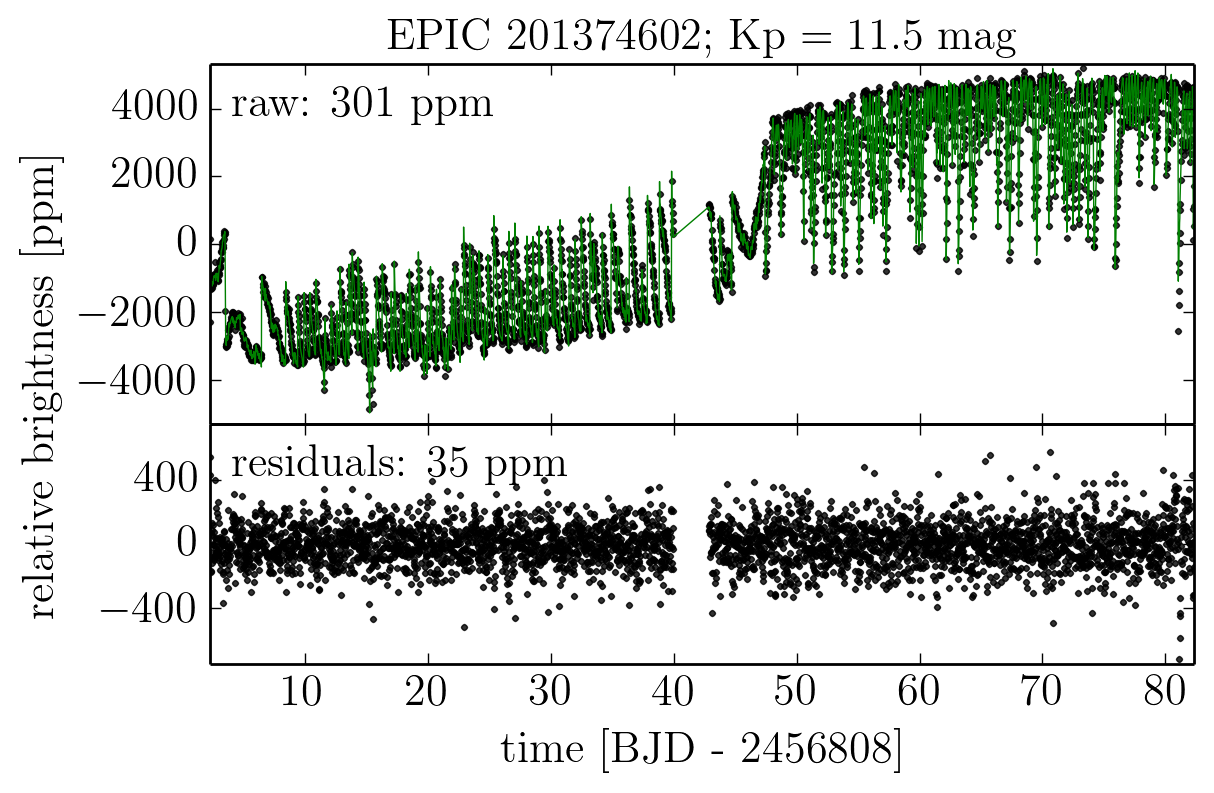

In [216]:
fig = pl.figure(figsize=(6, 4))
ax1 = pl.axes([0.16, 0.15+0.3, 0.82, 0.45])
ax2 = pl.axes([0.16, 0.15, 0.82, 0.3])

t = lc.time
y = lc.flux * 1e-3
ax1.plot(t, y*1e6, ".k", alpha=0.8, ms=4)
ax1.plot(t, mu * 1e3, "g", lw=0.5)
c = compute_cdpp(t, y+1, 6.0)
ax1.annotate("raw: {0:.0f} ppm".format(c),
             xy=(0, 1), xycoords="axes fraction",
             xytext=(8, -8), textcoords="offset points",
             ha="left", va="top", fontsize=16)

y = (lc.flux - mu) * 1e-3
ax2.plot(t, y*1e6, ".k", alpha=0.8, ms=4)
c = compute_cdpp(t, y+1, 6.0)
ax2.annotate("residuals: {0:.0f} ppm".format(c),
             xy=(0, 1), xycoords="axes fraction",
             xytext=(8, -8), textcoords="offset points",
             ha="left", va="top", fontsize=16)

ax1.set_xlim(min(t), max(t))
ax1.set_ylim(-0.0053*1e6, 0.0053*1e6)

ax2.set_xlim(min(t), max(t))
ax2.set_ylim(-0.00075*1e6, 0.00075*1e6)
ax2.yaxis.set_major_locator(MaxNLocator(5))

ax1.set_title("EPIC {0}; Kp $ = {1:.1f}$ mag".format(epicid, star.kp),
              fontsize=16)
ax1.set_xticklabels([])

ax2.set_xlabel("time [BJD - {0}]".format(base_time))
fig.text(0.02, 0.5, "relative brightness [ppm]", ha="center", va="center", rotation="vertical")
fig.savefig("corr.pdf")

3.6725129208


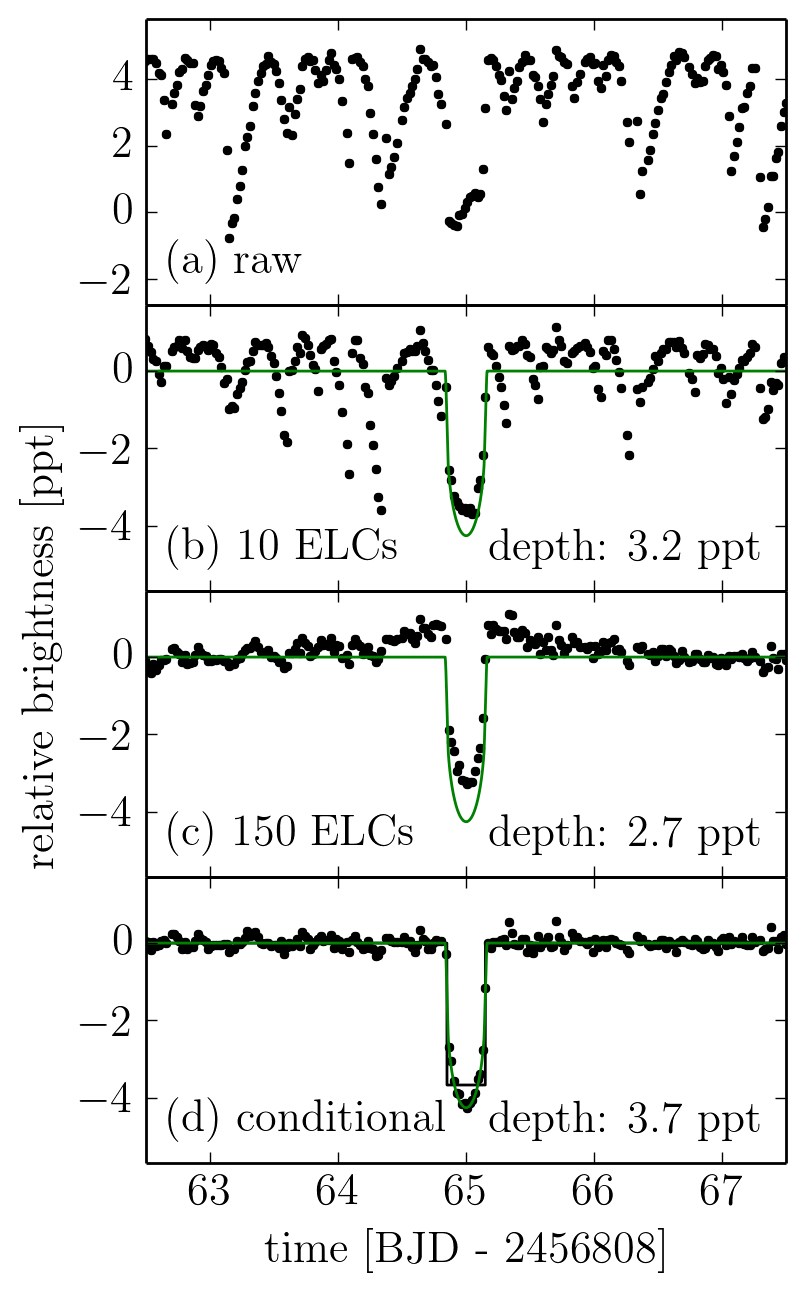

In [231]:
import transit

# Inject a transit.
x = np.array(lc.time)
y = np.array(lc.flux)
s = transit.System(transit.Central())
s.add_body(transit.Body(period=100.0, r=0.06, t0=65.0, b=0.5))
truth = s.light_curve(x)
y = ((y*1e-3 + 1) * truth - 1)*1e3
truth = (truth - 1) * 1e3

x0 = np.linspace(62, 68, 5000)
y0 = (s.light_curve(x0) - 1) * 1e3

fig, axes = pl.subplots(4, 1, figsize=(4, 6.5), sharex=True)
axes[-1].set_xlim(62.5, 67.5)
for i, ax in enumerate(axes):
    ax.yaxis.set_major_locator(MaxNLocator(5))
    if i > 0:
        ax.set_ylim(-5.7, 1.7)
    else:
        ax.set_ylim(-2.8, 5.8)

# Plot the raw light curve.
axes[0].plot(x, y, ".k")
axes[0].annotate("(a) raw",
             xy=(0, 0), xycoords="axes fraction",
             xytext=(8, 8), textcoords="offset points",
             ha="left", va="bottom", fontsize=16)

# The box model.
model = np.zeros_like(x)
m = np.abs(x - 65.0) < 0.15
model[m] = -1

# Fit out a small model.
AT = np.concatenate((lc.basis[:10], np.ones((1, len(x)))), axis=0)
A = AT.T
w = np.linalg.solve(np.dot(AT, A), np.dot(AT, y))
mu = np.dot(A, w)
axes[1].plot(x, y - mu, ".k")
axes[1].plot(x0, y0, "g")
depth = np.mean((y-mu)[~m]) - np.mean((y-mu)[m])
axes[1].annotate("(b) 10 ELCs",
             xy=(0, 0), xycoords="axes fraction",
             xytext=(8, 8), textcoords="offset points",
             ha="left", va="bottom", fontsize=16)
axes[1].annotate("depth: {0:.1f} ppt".format(depth),
             xy=(1, 0), xycoords="axes fraction",
             xytext=(-8, 8), textcoords="offset points",
             ha="right", va="bottom", fontsize=16)

# Fit out the full model.
mu = lc.predict(y)
axes[2].plot(x, y - mu, ".k")
axes[2].plot(x0, y0, "g")
depth = np.mean((y-mu)[~m]) - np.mean((y-mu)[m])
axes[2].annotate("(c) 150 ELCs",
             xy=(0, 0), xycoords="axes fraction",
             xytext=(8, 8), textcoords="offset points",
             ha="left", va="bottom", fontsize=16)
axes[2].annotate("depth: {0:.1f} ppt".format(depth),
             xy=(1, 0), xycoords="axes fraction",
             xytext=(-8, 8), textcoords="offset points",
             ha="right", va="bottom", fontsize=16)

# Now fit with the conditional model.
AT = np.concatenate((lc.basis, model[None, :]), axis=0)
A = AT.T
w = np.linalg.solve(np.dot(AT, A), np.dot(AT, y))
bkg = np.dot(A[:, :-1], w[:-1])

model = model = np.zeros_like(x0)
m = np.abs(x0 - 65.0) < 0.15
model[m] = -w[-1]
print(w[-1])
axes[3].plot(x, y - bkg, ".k")
axes[3].plot(x0, model, "k")
axes[3].plot(x0, y0, "g")

axes[3].annotate("(d) conditional",
             xy=(0, 0), xycoords="axes fraction",
             xytext=(8, 8), textcoords="offset points",
             ha="left", va="bottom", fontsize=16)
axes[3].annotate("depth: {0:.1f} ppt".format(w[-1]),
             xy=(1, 0), xycoords="axes fraction",
             xytext=(-8, 8), textcoords="offset points",
             ha="right", va="bottom", fontsize=16)
        
axes[-1].set_xlabel("time [BJD - {0}]".format(base_time))
fig.text(0.04, 0.5, "relative brightness [ppt]", ha="center", va="center", rotation="vertical")

fig.subplots_adjust(left=0.17, bottom=0.1, top=0.98, right=0.97, hspace=0.)
fig.savefig("overfitting.pdf")